Would like to see how large our radiometric error bars are for various integration times and binning things.

In [1]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial
import alm_polynomial_inference as api
from src.inference import curve_fit_emcee
import src.observing as OBS
import src.map_making as MM
import src.spherical_harmonics as SH

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

alm2temp = 1/np.sqrt(4*np.pi)

In [12]:
# Model and observation params
nside   = 32
lmax    = 32
Nlmax   = RS.get_size(lmax)
lats  = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#np.linspace(-80, 80, 100)#[-26]#
times = np.linspace(0, 24, 12, endpoint=False)
Ntau  = 1
nuarr = np.linspace(50,100,51)
cm21_params = OBS.cm21_params

# Generate foreground and 21-cm alm
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fid_alm  = fg_alm + cm21_alm


narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
mat_G = BlockMatrix(mat=mat_G, mode='block', nblock=len(nuarr))
mat_P = BlockMatrix(mat=mat_P, mode='block', nblock=len(nuarr))
mat_Y = BlockMatrix(mat=mat_Y, mode='block', nblock=len(nuarr))
mat_B = BlockMatrix(mat=mat_B, mode='block', nblock=len(nuarr))
# Perform fiducial observations without binning.
d = mat_P @ mat_Y @ mat_B @ fid_alm
np.save("saves/Binwise/mat_PYB.npy", (mat_P @ mat_Y @ mat_B).matrix)
dnoisy, noise_covar = SM.add_noise(d, nuarr[1]-nuarr[0], len(times), t_int=100)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


In [19]:
noise = BlockVector(np.sqrt(noise_covar.diag), nblock=len(nuarr))

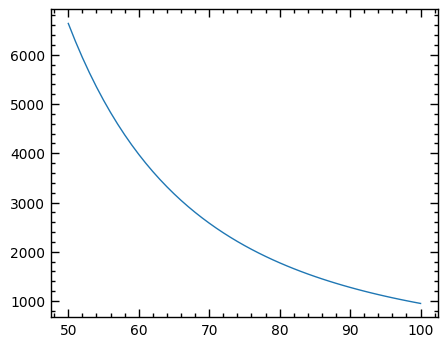

In [23]:
plt.plot(nuarr,dnoisy[12])

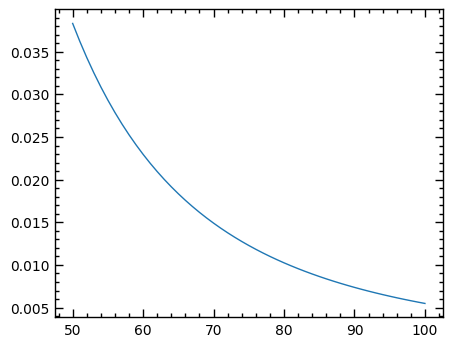

In [22]:
plt.plot(nuarr,noise[12])

In [24]:
# Model and observation params
nside   = 32
lmax    = 32
Nlmax   = RS.get_size(lmax)
lats  = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#np.linspace(-80, 80, 100)#[-26]#
times = np.linspace(0, 24, 12, endpoint=False)
Ntau  = 1
nuarr = np.linspace(50,100,51)
cm21_params = OBS.cm21_params

# Generate foreground and 21-cm alm
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fid_alm  = fg_alm + cm21_alm


narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
mat_G = BlockMatrix(mat=mat_G, mode='block', nblock=len(nuarr))
mat_P = BlockMatrix(mat=mat_P, mode='block', nblock=len(nuarr))
mat_Y = BlockMatrix(mat=mat_Y, mode='block', nblock=len(nuarr))
mat_B = BlockMatrix(mat=mat_B, mode='block', nblock=len(nuarr))

d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, nuarr[1]-nuarr[0], Ntau, t_int=100)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [25]:
noise = BlockVector(np.sqrt(noise_covar.diag), nblock=len(nuarr))

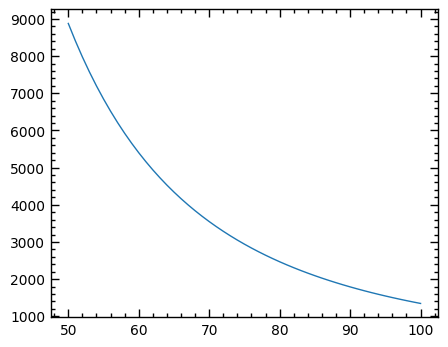

In [26]:
plt.plot(nuarr,dnoisy[0])

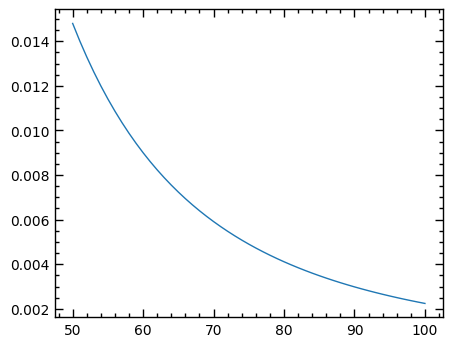

In [27]:
plt.plot(nuarr,noise[0])